In [1]:
!pip install opencv-python wget


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7c759391f44d778508badb57cd0ecbb885877625cf642673cccd330c5bce6dcc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [7]:
import wget

# URLs for the required YOLO files
weights_url = 'https://pjreddie.com/media/files/yolov3.weights'
cfg_url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
names_url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'

# Download files
wget.download(weights_url)
wget.download(cfg_url)
wget.download(names_url)


'coco (1).names'

In [8]:
import cv2
import numpy as np

def load_yolo_model():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    return net, classes, output_layers, colors

net, classes, output_layers, colors = load_yolo_model()


In [17]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

def load_image(image_path):
    img = cv2.imread(image_path)
    height, width, channels = img.shape
    return img, height, width, channels

img, height, width, channels = load_image(image_path)


Saving mqdefault.jpg to mqdefault.jpg


In [18]:

def detect_objects(net, output_layers, img):
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    return outs

outs = detect_objects(net, output_layers, img)


In [19]:
def process_detections(outs, width, height, conf_threshold=0.5, nms_threshold=0.4):
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    return boxes, confidences, class_ids, indexes

boxes, confidences, class_ids, indexes = process_detections(outs, width, height)

def draw_bounding_boxes(img, boxes, confidences, class_ids, indexes, classes, colors):
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

draw_bounding_boxes(img, boxes, confidences, class_ids, indexes, classes, colors)


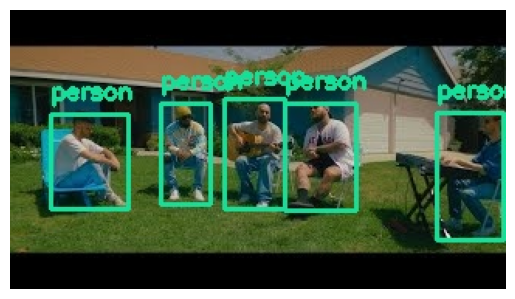

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

def save_and_display_image(img, output_path='output.jpg'):
    cv2.imwrite(output_path, img)
    img_pil = Image.open(output_path)
    plt.imshow(np.asarray(img_pil))
    plt.axis('off')
    plt.show()

save_and_display_image(img)
